In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

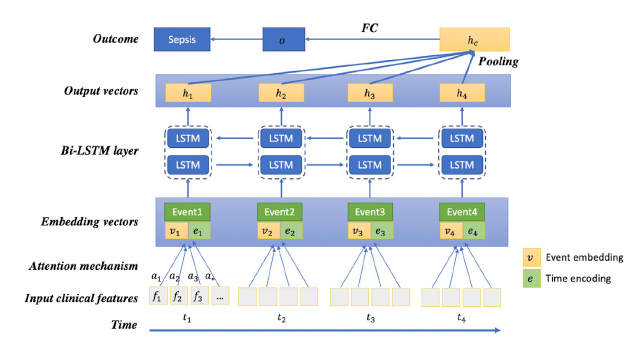

We mapped the feature variables into vectors via an
embedding layer. The concatenation of the embedding vectors
and the observed feature values were then input to the RNN
models.

In [3]:
no_sepsis_df = pd.read_csv("feature_selection_no_sepsis_transformed2.csv")
sepsis_df = pd.read_csv("feature_selection_sepsis_transformed2.csv")

In [4]:
sepsis_df = sepsis_df.groupby('hadm_id').filter(lambda x: len(x) >= 4)
no_sepsis_df = no_sepsis_df.groupby('hadm_id').filter(lambda x: len(x) >= 4)

In [5]:
sepsis_df['hour'] = sepsis_df.groupby('hadm_id')['hour'].transform(lambda x: x.max() - x)
no_sepsis_df['hour'] = no_sepsis_df.groupby('hadm_id')['hour'].transform(lambda x: x.max() - x)

sepsis_df['Gender'] = sepsis_df['Gender'].map({'M': 0, 'F': 1})
no_sepsis_df['Gender'] = no_sepsis_df['Gender'].map({'M': 0, 'F': 1})

In [6]:
sepsis_df.head()

,hadm_id,hour,Age,Gender,Unit,AST,Abs_Basophils_Blood,Abs_Lymph_Count,Abs_Mono,Abs_Neutrophil,...,Sodium,Specific_Gravity_Urine,TSH,Temp,Triglycerides,Urobilinogen,Vitamin_B12,WBC,Weight,pH
3,20005119.0,58.57,56,1,Trauma SICU (TSICU),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20005119.0,57.57,56,1,Trauma SICU (TSICU),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,20005119.0,56.57,56,1,Trauma SICU (TSICU),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,20005119.0,55.57,56,1,Trauma SICU (TSICU),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,36.111111,NaN,NaN,NaN,NaN,NaN,NaN
7,20005119.0,54.57,56,1,Trauma SICU (TSICU),NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Model training

In [7]:
def process_patient_data(df, feature_columns):
    processed_data = []
    time_encodings = []
    
    for hadm_id, patient_df in df.groupby('hadm_id'):
        patient_df = patient_df.sort_values(by='hour')
        num_rows = len(patient_df)
        split_sizes = [num_rows // 4 + (1 if i < num_rows % 4 else 0) for i in range(4)]
        
        start_idx = 0
        patient_splits = []
        patient_time_encodings = []
        
        for size in split_sizes:
            split_df = patient_df.iloc[start_idx:start_idx + size]
            median_features = split_df[feature_columns].mean().values
            time_encoding = np.array([[split_df['hour'].max() - split_df['hour'].min()]])
            
            patient_splits.append(median_features)
            patient_time_encodings.append(time_encoding)
            start_idx += size
        
        processed_data.append(patient_splits)
        time_encodings.append(patient_time_encodings)
    
    return np.array(processed_data), np.array(time_encodings)

feature_columns = [col for col in sepsis_df.columns if col not in ['hour', 'hadm_id', 'Unit']]

X_sepsis, time_sepsis = process_patient_data(sepsis_df, feature_columns)
X_no_sepsis, time_no_sepsis = process_patient_data(no_sepsis_df, feature_columns)

y_sepsis = np.ones(len(X_sepsis))
y_no_sepsis = np.zeros(len(X_no_sepsis))

X = np.concatenate([X_sepsis, X_no_sepsis], axis=0)
time_encodings = np.concatenate([time_sepsis, time_no_sepsis], axis=0)
y = np.concatenate([y_sepsis, y_no_sepsis], axis=0)

train_idx, test_idx = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42, stratify=y)
X_train, X_test = X[train_idx], X[test_idx]
time_train, time_test = time_encodings[train_idx], time_encodings[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train_split = [X_train[:, i, :] for i in range(4)]
X_test_split = [X_test[:, i, :] for i in range(4)]
time_train_split = [time_train[:, i, :] for i in range(4)]
time_test_split = [time_test[:, i, :] for i in range(4)]

In [8]:
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

In [11]:
num_splits = 4  # Número de trechos da internação
num_features = 72  # Número de features por input
embedding_dim = 16  # Dimensão do embedding
lstm_units = 4  # Unidades LSTM

def build_model(input_shape=(72,), num_splits=4):
    input_layers = []
    embedding_layers = []
    time_encoding_inputs = []
    
    for i in range(num_splits):
        input_layer = Input(shape=input_shape, name=f'input_{i}')
        input_layers.append(input_layer)
        
        time_encoding = Input(shape=(1, 1), name=f'time_encoding_{i}')
        time_encoding_inputs.append(time_encoding)
        
        embedding_layer = Dense(16, activation='relu')(input_layer)
        concatenated = Concatenate()([embedding_layer, tf.keras.layers.Flatten()(time_encoding)])
        embedding_layers.append(concatenated)
    
    # Expand dimensions for Bi-LSTM processing
    expanded_layers = [Lambda(lambda x: tf.expand_dims(x, axis=1))(layer) for layer in embedding_layers]
    merged_sequence = Concatenate(axis=1)(expanded_layers)
    
    # Bi-LSTM layer
    bi_lstm_layer = Bidirectional(LSTM(4, return_sequences=True))(merged_sequence)
    max_pooled = GlobalMaxPooling1D()(bi_lstm_layer)
    
    # Fully connected layers
    fc_layer = Dense(16, activation='relu')(max_pooled)
    output_layer = Dense(1, activation='sigmoid')(fc_layer)
    
    model = Model(inputs=input_layers + time_encoding_inputs, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_0             │ (None, 72)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_0     │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_1             │ (None, 72)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_1     │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 72)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_2     │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3             │ (None, 72)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_encoding_3     │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      1,168 │ input_0[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ time_encoding_0[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,168 │ input_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ time_encoding_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │      1,168 │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ time_encoding_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │      1,168 │ input_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ time_encoding_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 17)        │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 17)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 17)        │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,537 (21.63 KB)

 Trainable params: 5,537 (21.63 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

X_train_final = X_train_split + time_train_split
X_test_final = X_test_split + time_test_split

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_final, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_test_final, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/40
990/990 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7985 - loss: 0.4409 - val_accuracy: 0.8884 - val_loss: 0.3001
Epoch 2/40
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8922 - loss: 0.2915 - val_accuracy: 0.8951 - val_loss: 0.2848
Epoch 3/40
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8954 - loss: 0.2811 - val_accuracy: 0.8967 - val_loss: 0.2774
Epoch 4/40
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8981 - loss: 0.2732 - val_accuracy: 0.8987 - val_loss: 0.2699
Epoch 5/40
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9003 - loss: 0.2673 - val_accuracy: 0.8999 - val_loss: 0.2670
Epoch 6/40
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9015 - loss: 0.2647 - val_accuracy: 0.9019 - val_loss: 0.2634
Epoch 7/40
990/990 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9067 - loss: 0.2585 - val_accuracy: 0.8990 - val_loss: 0.2710
Epoch 8/40
990/990 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9047 - loss: 0.2578 - val_accuracy: 0.

248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.9034
Recall: 0.5740
F1-score: 0.6763
              precision    recall  f1-score   support

         0.0     0.9147    0.9736    0.9432      6527
         1.0     0.8229    0.5740    0.6763      1392

    accuracy                         0.9034      7919
   macro avg     0.8688    0.7738    0.8097      7919
weighted avg     0.8985    0.9034    0.8963      7919

AUROC: 0.8970


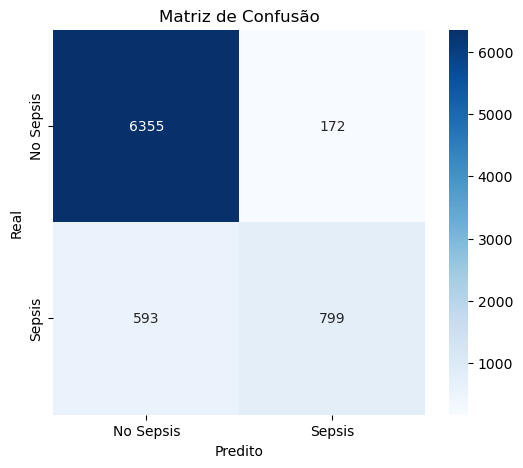

In [15]:
y_pred_prob = model.predict(X_test_final)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

print(classification_report(y_test, y_pred, digits=4))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
auroc = roc_auc
print(f"AUROC: {auroc:.4f}")
y_pred_prob = y_pred_prob.flatten()

results_df = pd.DataFrame({
    'y_true': y_test,
    'y_prob': y_pred_prob
})

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sepsis', 'Sepsis'], yticklabels=['No Sepsis', 'Sepsis'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

### Conformal Prediction

In [12]:
%matplotlib inline
from scipy.stats import rankdata
import openml

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize

import plotly.express as px
# from catboost import CatBoostClassifier

In [13]:
def InverseProbabilityNC(predicted_score, y):
  prob = np.zeros(y.size, dtype=np.float32)
  for i, y_ in enumerate(y):
    if y_ >= predicted_score.shape[1]:
      prob[i] = 0
    else:
      prob[i] = predicted_score[i, int(y_)]
  return 1 - prob

def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
  p_values = []
  if not isinstance(non_conformity_scores_test, list):
    non_conformity_scores_test = [non_conformity_scores_test]

  for i, test_point_conformity_score in enumerate(non_conformity_scores_test):
    p_value = (np.sum(non_conformity_scores_train >= test_point_conformity_score) + 1) / (len(non_conformity_scores_train)+1)
    p_values.append(p_value)  
  return np.array(p_values)

In [14]:
from joblib import Parallel, delayed

def process_sample(i, X_train, y_train, X_test, y_test, significance_level):
    print(f"Processing sample {i+1}/{len(y_test)}")

    # Adiciona a amostra de teste ao conjunto de treino
    X_train_plus_test = [list(X_train[j]) for j in range(8)]
    for idx_array in range(8):
        X_train_plus_test[idx_array].append(X_test[idx_array][i])
    X_train_plus_test = [np.array(arr) for arr in X_train_plus_test]

    y_train_plus_test_0 = np.append(y_train, 0)
    y_train_plus_test_1 = np.append(y_train, 1)

    modelA = build_model()
    modelA.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    modelB = build_model()
    modelB.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    modelA.fit(X_train_plus_test, y_train_plus_test_0, epochs=10, batch_size=32, verbose=0)
    modelB.fit(X_train_plus_test, y_train_plus_test_1, epochs=10, batch_size=32, verbose=0)

    y_pred_score_train_plus_test_0 = modelA.predict(X_train_plus_test)
    y_pred_score_train_plus_test_1 = modelB.predict(X_train_plus_test)

    y_pred_score_train_plus_test_0 = np.hstack([1 - y_pred_score_train_plus_test_0, y_pred_score_train_plus_test_0])
    y_pred_score_train_plus_test_1 = np.hstack([1 - y_pred_score_train_plus_test_1, y_pred_score_train_plus_test_1])

    # Cálculo dos non-conformity scores
    nc_scores_0 = InverseProbabilityNC(y_pred_score_train_plus_test_0, y_train_plus_test_0)
    nc_scores_1 = InverseProbabilityNC(y_pred_score_train_plus_test_1, y_train_plus_test_1)

    p_value_class_0 = compute_p_value(nc_scores_0[:-1], nc_scores_0[-1])
    p_value_class_1 = compute_p_value(nc_scores_1[:-1], nc_scores_1[-1])

    if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
        prediction_set = [True, True]
    elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
        prediction_set = [True, False]
    elif (p_value_class_0 <= significance_level) and (p_value_class_1 > significance_level):
        prediction_set = [False, True]
    else:
        prediction_set = [False, False]

    print(f"Sample {i}:")
    print(f"  y_pred_score_train_plus_test_1[-1] = {y_pred_score_train_plus_test_1[-1]}")
    print(f"  nc_scores_1[-1] = {nc_scores_1[-1]}")
    print(f"  p_value_class_1 = {p_value_class_1}")
    return prediction_set, p_value_class_0, p_value_class_1


def parallel_prediction_sets(X_train, y_train, X_test, y_test, significance_level=0.05, n_jobs=4):
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_sample)(i, X_train, y_train, X_test, y_test, significance_level)
        for i in range(len(y_test))
    )

    prediction_sets, p_values_class_0, p_values_class_1 = zip(*results)
    return list(prediction_sets), list(p_values_class_0), list(p_values_class_1)


In [19]:
# Exemplo de uso:
predictions_test_sets, p_values_test_set_class_0, p_values_test_set_class_1 = parallel_prediction_sets(
    X_train_final, y_train, X_test_final, y_test[2000:3000], significance_level=0.05, n_jobs=-1
)

C:\Users\55549\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [20]:
import pickle

with open(f'mimiciv_p_values_class_0[2000-3000].pkl', 'wb') as f:
    pickle.dump(p_values_test_set_class_0, f)

with open(f'mimiciv_p_values_class_1[2000-3000].pkl', 'wb') as f:
    pickle.dump(p_values_test_set_class_1, f)

In [ ]:
# X_test_final_limited = [array[:500] for array in X_test_final]
predictions_test_sets, p_values_test_set_class_0, p_values_test_set_class_1  = prediction_sets(
    X_train_final, y_train, X_test_final, y_test[200:500], model=LogisticRegression(), significance_level = 0.05)

0
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
1
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
2
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
3
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
4
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
5
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
6
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
7
990/990 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
8
990/990 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step
9
990/990 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step
10
990/990 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step
990/990 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step
11
990/990 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
990/990 ━━━━━━━━━━━━━

In [31]:
import pickle

with open(f'mimiciv_p_values_class_0[:2000].pkl', 'wb') as f:
    pickle.dump(p_values_test_set_class_0, f)

with open(f'mimiciv_p_values_class_1[:2000].pkl', 'wb') as f:
    pickle.dump(p_values_test_set_class_1, f)

In [21]:
import pickle

with open(f'mimiciv_p_values_class_0[0-2000].pkl', 'rb') as f:
    p_values_test_set_class_0 = pickle.load(f)

with open(f'mimiciv_p_values_class_1[0-2000].pkl', 'rb') as f:
    p_values_test_set_class_1 = pickle.load(f)

with open('mimiciv_p_values_class_0[2000-3000].pkl', 'rb') as f:
    p_values_test_set_class_0_2 = pickle.load(f)

with open('mimiciv_p_values_class_1[2000-3000].pkl', 'rb') as f:
    p_values_test_set_class_1_2 = pickle.load(f)
    
p_values_test_set_class_0 = np.concatenate([p_values_test_set_class_0, p_values_test_set_class_0_2])
p_values_test_set_class_1 = np.concatenate([p_values_test_set_class_1, p_values_test_set_class_1_2])

In [23]:
def conformal_prediction_metrics(p_values_class_0, p_values_class_1, y_test, significance_level):
    predictions_test_set = []

    for p0, p1 in zip(p_values_class_0, p_values_class_1):
        if (p0 > significance_level) and (p1 > significance_level):
            predictions_test_set.append(0 if p0 > p1 else 1)
        elif (p0 > significance_level) and (p1 <= significance_level):
            predictions_test_set.append(0)
        elif (p0 <= significance_level) and (p1 > significance_level):
            predictions_test_set.append(1)
        else:
            predictions_test_set.append(None)

    valid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is not None]
    invalid_indices = [i for i, pred in enumerate(predictions_test_set) if pred is None]

    # Corrigido: usar iloc para acessar os valores pela posição
    y_test_valid = [y_test[i] for i in valid_indices]
    y_pred_valid = [predictions_test_set[i] for i in valid_indices]

    accuracy = accuracy_score(y_test_valid, y_pred_valid)
    recall = recall_score(y_test_valid, y_pred_valid)
    f1 = f1_score(y_test_valid, y_pred_valid)
    y_score = [1 - p[0] for p in p_values_test_set_class_0]  # ou p_values_class_1

    # Filtrando os mesmos índices válidos
    y_score_valid = [y_score[i] for i in valid_indices]
    
    fpr, tpr, thresholds = roc_curve(y_test_valid, y_score_valid)
    auroc = auc(fpr, tpr)

    conf_matrix = confusion_matrix(y_test_valid, y_pred_valid)
    report = classification_report(y_test_valid, y_pred_valid, digits=4)

    results_df = pd.DataFrame({
        'y_true': [y_test[i] for i in valid_indices],
        'y_pred': [y_score[i] for i in valid_indices]
    })
    #results_df.to_csv('../resultados/kam_cp_original_005.csv')

    coverage_rate = len(valid_indices) / len(y_test)
    set_size = np.mean([
        int(p_values_class_0[i] > significance_level) + int(p_values_class_1[i] > significance_level)
        for i in range(len(y_test))
    ])

    y_test_np = y_test
    removed_sepsis = np.sum(y_test_np[invalid_indices] == 1)
    removed_no_sepsis = np.sum(y_test_np[invalid_indices] == 0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUROC: {auroc:.4f}")
    print(f"Coverage Rate: {coverage_rate:.4f}")
    print(f"Set Size (avg prediction set size): {set_size:.4f}")
    print(f"Removed samples (No sepsis): {removed_no_sepsis}")
    print(f"Removed samples (Sepsis): {removed_sepsis}")
    print("\nClassification Report:")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No sepsis', 'Sepsis'],
                yticklabels=['No sepsis', 'Sepsis'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'recall': recall,
        'f1_score': f1,
        'auroc': auroc,
        'coverage_rate': coverage_rate,
        'set_size': set_size,
        'removed_sepsis': removed_sepsis,
        'removed_no_sepsis': removed_no_sepsis,
        'results_df': results_df
    }

Accuracy: 0.8711
Recall: 0.4033
F1-score: 0.4921
AUROC: 0.7391
Coverage Rate: 0.9127
Set Size (avg prediction set size): 0.9137
Removed samples (No sepsis): 170
Removed samples (Sepsis): 92

Classification Report:
              precision    recall  f1-score   support

         0.0     0.8974    0.9568    0.9262      2314
         1.0     0.6310    0.4033    0.4921       424

    accuracy                         0.8711      2738
   macro avg     0.7642    0.6800    0.7091      2738
weighted avg     0.8562    0.8711    0.8589      2738



C:\Users\55549\AppData\Local\Temp\ipykernel_9772\1995542198.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  int(p_values_class_0[i] > significance_level) + int(p_values_class_1[i] > significance_level)


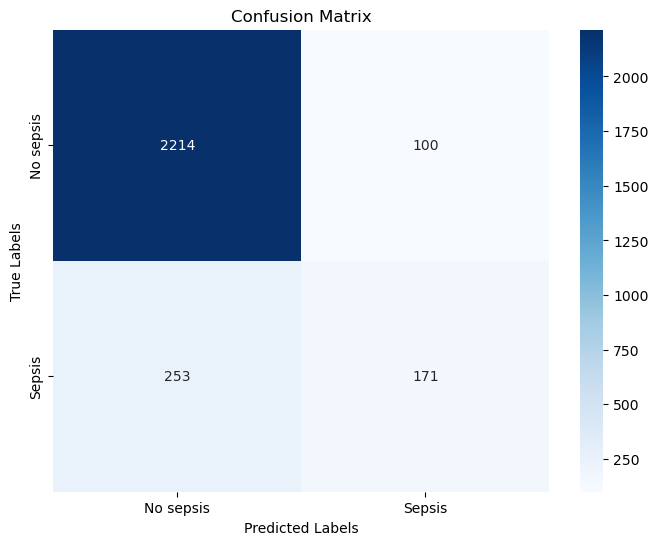

In [41]:
metrics = conformal_prediction_metrics(
    p_values_class_0=p_values_test_set_class_0,
    p_values_class_1=p_values_test_set_class_1,
    y_test=y_test[:len(p_values_test_set_class_0)],  # lista ou array com rótulos verdadeiros
    significance_level=0.15
)